In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from scipy.optimize import curve_fit
from ROOT import TVector3
import perform_calibrations as pc #import perform calibration package to get data
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import ROOT
import array
import matplotlib
from matplotlib import rc
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
rc('text', usetex=False)
import scipy as sp
from scipy.stats import gaussian_kde
from scipy.stats import norm
from scipy.signal import chirp, find_peaks, peak_widths, peak_prominences
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema

Welcome to JupyROOT 6.22/02


In [2]:
t = pc.tpc_calibration()

In [3]:
recoils = t.calibrate_recoils(corrected_energy = True, corrected_length = 0)

# Semi-loose x-ray veto
#### Use uncorrected energies for this, as x-rays may blend into recoil bands after correcting

In [32]:
### PERFORM CUTS
for tpc in ['iiwi', 'humu', 'nene', 'tako', 'palila', 'elepaio']:
    recoils[tpc] = recoils[tpc].loc[recoils[tpc]['track_energy']>6] #initial x-ray veto
    recoils[tpc].index = [i for i in range(0,len(recoils[tpc]))] #reindex
    # TPC QUADRATIC CUTS
    
    y = np.array([6,20,800])
    if tpc == 'iiwi':
        x = np.array([1200, 1900, 15000])
    elif tpc == 'humu':
        x = np.array([1950, 3000, 20000])
    elif tpc == 'nene':
        x = np.array([950, 1900, 15000])
    elif tpc == 'tako':
        x = np.array([1000, 1900, 15000])
    elif tpc == 'palila':
        x = np.array([1000, 1750, 15000])
    else:
        x = np.array([1050, 2000, 15000])
    cut = np.polyfit(x,y,2)
    
    recoils[tpc] = recoils[tpc].loc[ #x-ray veto quadratic cut recoil
        recoils[tpc]['track_energy'] > cut[0]*recoils[tpc]['length']**2
        +cut[1]*recoils[tpc]['length']+cut[2]] #after this cut, only recoil bands remain

### Plot uncorrected and corrected recoil bands

<ipython-input-19-896205d83006>:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cmap.set_under(color='white')


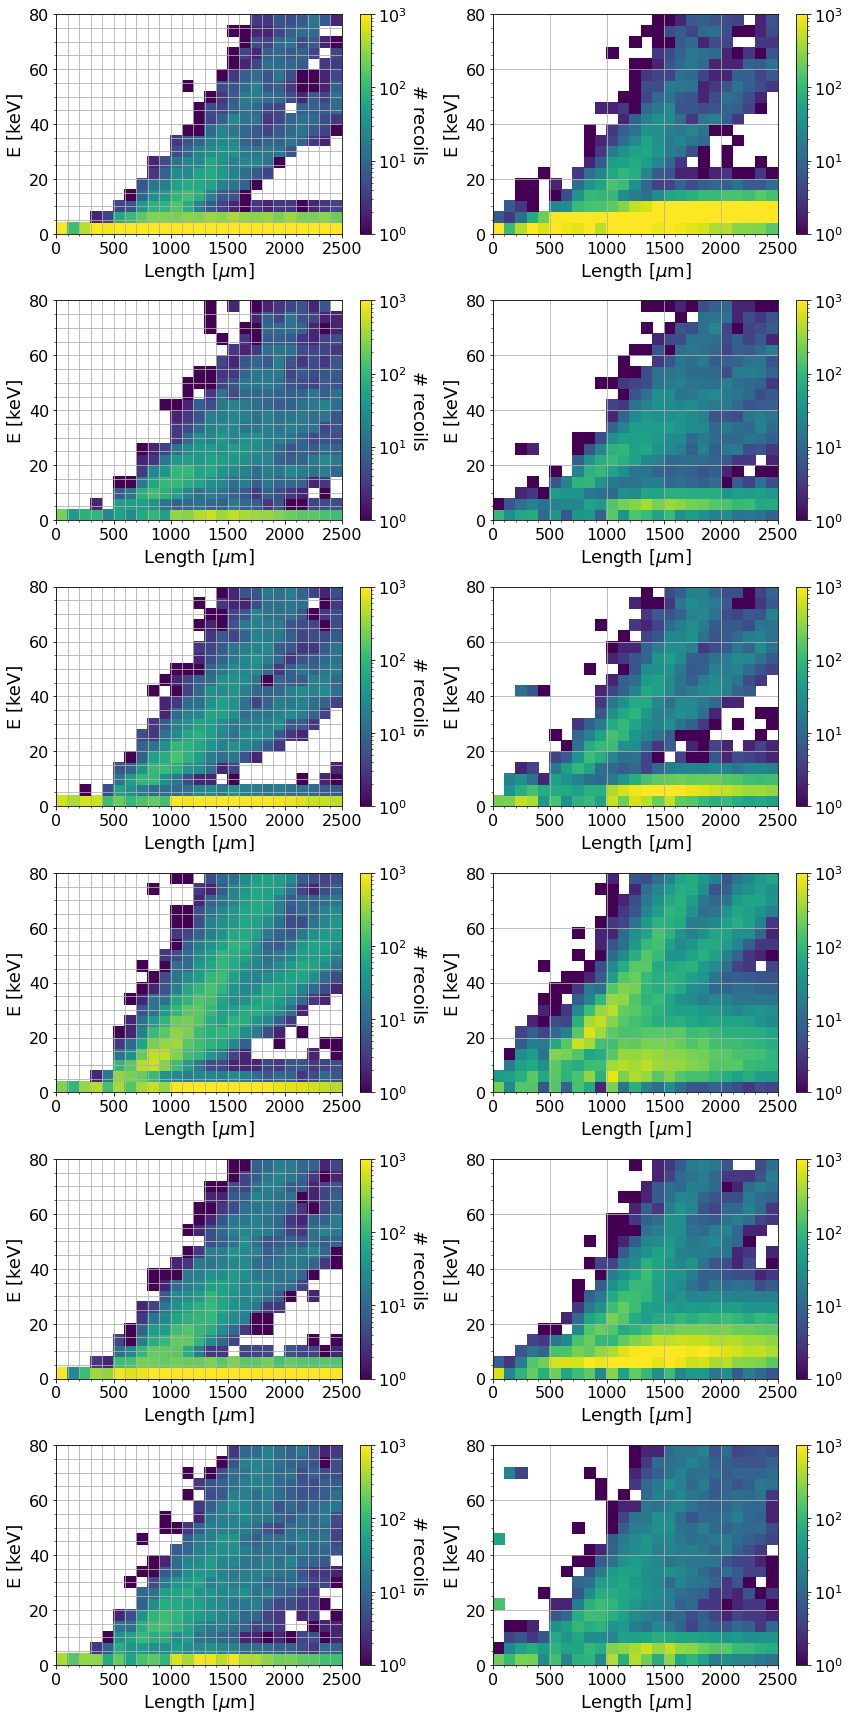

In [19]:
fig = plt.figure(figsize = (12,24))
cmap = plt.cm.viridis
cmap.set_under(color='white')
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=18)
    
xm = 10000
ym = 400
nbinsx = int(xm/100)
nbinsy = int(ym/4)

h = {}
image = {}

i = 1
for tpc in ['iiwi', 'humu', 'nene', 'tako', 'palila', 'elepaio']:
    p = plt.subplot(6,2,i)
    p.xaxis.set_minor_locator(AutoMinorLocator())
    p.yaxis.set_minor_locator(AutoMinorLocator())
    h[tpc + '_uncor'], xedges, yedges, image[tpc + '_uncor'] = plt.hist2d(recoils[tpc]['length'], recoils[tpc]['track_energy'], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=100))
    plt.ylim(0,300)
    plt.xlim(0,5500)
    plt.xlabel(r'Length [$\mu$m]')
    plt.ylabel('E [keV]')
    plt.title('%s Uncorrected'%(tpc.upper()))
    plt.colorbar()
    plt.grid(which = 'both')
    p = plt.subplot(6,2,i+1)
    p.xaxis.set_minor_locator(AutoMinorLocator())
    p.yaxis.set_minor_locator(AutoMinorLocator())
    h[tpc + '_cor'], xedges, yedges, image[tpc + '_cor'] = plt.hist2d(recoils[tpc]['length'], recoils[tpc]['full_corrected_energy'], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=100))
    plt.ylim(0,300)
    plt.xlim(0,5500)
    plt.xlabel(r'Length [$\mu$m]')
    plt.ylabel('E [keV]')
    plt.title('%s Corrected'%(tpc.upper()))
    plt.colorbar()
    plt.grid(which = 'both')
    i += 2

plt.tight_layout()
plt.show()

### Plot He recoil band cuts to be used as training sample for double gaussian fitter

<ipython-input-36-cf9e548a7b9a>:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cmap.set_under(color='white')


iiwi [8.33333333e-06 4.50000000e-02 1.66666667e+01]
humu [8.33333333e-06 2.83333333e-02 5.00000000e+01]
nene [8.33333333e-06 4.50000000e-02 1.66666667e+01]
tako [1.11111111e-05 6.55555556e-02 1.44444444e+01]
palila [1.11111111e-05 3.22222222e-02 6.11111111e+01]
elepaio [1.52777778e-05 2.97222222e-02 6.94444444e+01]


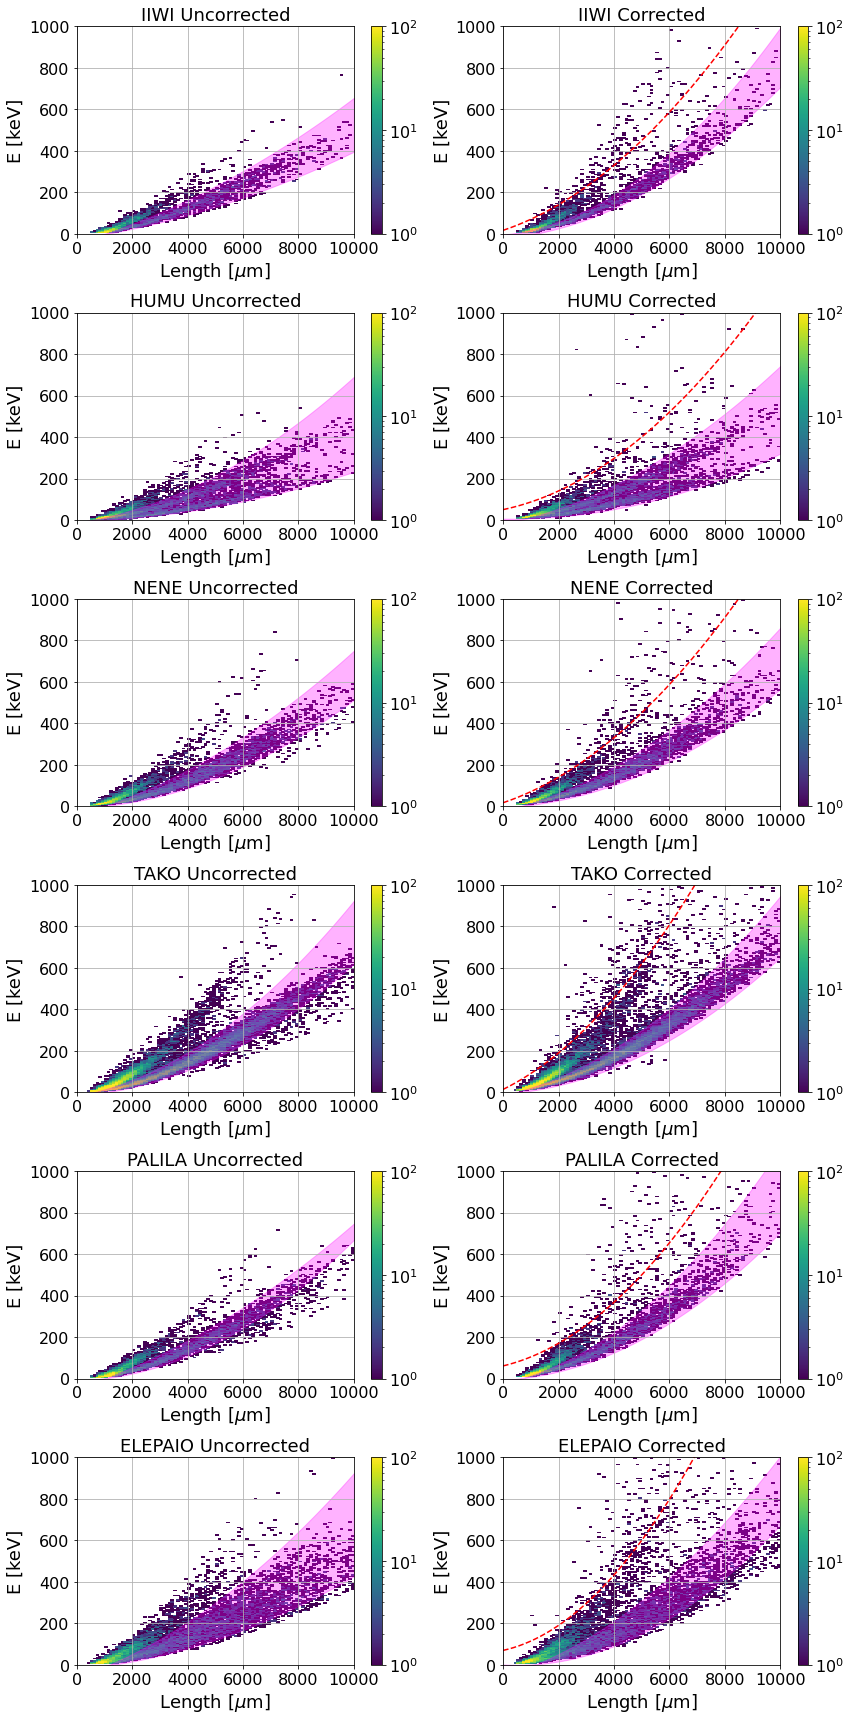

In [36]:
fig = plt.figure(figsize = (12,24))
cmap = plt.cm.viridis
cmap.set_under(color='white')
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=18)
    
xm = 10000
ym = 1000
nbinsx = int(xm/100)
nbinsy = int(ym/4)

h = {}
image = {}

x_plt = np.linspace(0,xm,xm+1)

i = 1
for tpc in ['iiwi', 'humu', 'nene', 'tako', 'palila', 'elepaio']:
    
    #UNCORRECTED RECOILS
    plt.subplot(6,2,i)
    
    x = np.array([2000, 2600, 5000])
    if tpc == 'iiwi':
        y_min = np.array([24, 42, 130])
        y_max = np.array([48, 80, 230])
    elif tpc == 'humu':
        y_min = np.array([10, 18, 64])
        y_max = np.array([48, 74, 214])
    elif tpc == 'nene':
        y_min = np.array([20, 36, 134])
        y_max = np.array([50, 84, 250])
    elif tpc == 'tako':
        y_min = np.array([24, 44, 164])
        y_max = np.array([60, 94, 280])
    elif tpc == 'palila':
        y_min = np.array([24, 44, 170])
        y_max = np.array([54, 90, 260])
    else:
        y_min = np.array([16, 32, 120])
        y_max = np.array([52, 94, 300])
        
    cut_min = np.polyfit(x,y_min,2)
    cut_max = np.polyfit(x,y_max,2)
    #print(tpc, cut_min, cut_max)
    
    h[tpc + '_uncor'], xedges, yedges, image[tpc + '_uncor'] = plt.hist2d(recoils[tpc]['length'], recoils[tpc]['track_energy'], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=100))
    plt.fill_between(x_plt, cut_min[0]*x_plt**2 + cut_min[1]*x_plt + cut_min[2],
                    cut_max[0]*x_plt**2 + cut_max[1]*x_plt + cut_max[2], color = 'magenta', alpha = 0.3)
    plt.ylim(0,ym)
    plt.xlim(0,xm)
    plt.xlabel(r'Length [$\mu$m]')
    plt.ylabel('E [keV]')
    plt.title('%s Uncorrected'%(tpc.upper()))
    plt.colorbar()
    plt.grid(which = 'both')
    
    #CORRECTED RECOILS
    plt.subplot(6,2,i+1)
    
    if tpc == 'iiwi':
        y_min = np.array([26, 50, 190])
        y_max = np.array([58, 90, 280])
        y_CO = np.array([140, 190, 450])
    elif tpc == 'humu':
        y_min = np.array([16, 24, 80])
        y_max = np.array([55, 85, 240])
        y_CO = np.array([140, 180, 400])
    elif tpc == 'nene':
        y_min = np.array([28, 46, 154])
        y_max = np.array([62, 96, 274])
        y_CO = np.array([140, 190, 450])
    elif tpc == 'tako':
        y_min = np.array([34, 55, 180])
        y_max = np.array([72, 108, 300])
        y_CO = np.array([190, 260, 620])
    elif tpc == 'palila':
        y_min = np.array([34, 56, 190])
        y_max = np.array([68, 108, 330])
        y_CO = np.array([170, 220, 500])
    else:
        y_min = np.array([16, 32, 150])
        y_max = np.array([52, 94, 310])
        y_CO = np.array([190, 250, 600])
        
    cut_min = np.polyfit(x,y_min,2)
    cut_max = np.polyfit(x,y_max,2)
    cut_CO = np.polyfit(x,y_CO,2)
    #print(tpc, cut_min, cut_max)
    print(tpc, cut_CO)
    h[tpc + '_cor'], xedges, yedges, image[tpc + '_cor'] = plt.hist2d(recoils[tpc]['length'], recoils[tpc]['full_corrected_energy'], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=100))
    plt.fill_between(x_plt, cut_min[0]*x_plt**2 + cut_min[1]*x_plt + cut_min[2],
                    cut_max[0]*x_plt**2 + cut_max[1]*x_plt + cut_max[2], color = 'magenta', alpha = 0.3)
    plt.plot(x_plt,cut_CO[0]*x_plt**2 + cut_CO[1]*x_plt + cut_CO[2], '--', color = 'red')
    plt.ylim(0,1000)
    plt.xlim(0,10000)
    plt.xlabel(r'Length [$\mu$m]')
    plt.ylabel('E [keV]')
    plt.title('%s Corrected'%(tpc.upper()))
    plt.colorbar()
    plt.grid(which = 'both')
    i += 2

plt.tight_layout()
plt.show()

### Apply cuts from He recoil bands

In [34]:
def apply_He_band_cuts(df, ecor = 'corrected'): #Cuts to train double Gaussian fit
    
    #FIRST APPLY INITIAL X-RAY VETO (already done if using .ipynb)
    
    df = df.loc[df['track_energy']>6] #initial x-ray veto
    df.index = [i for i in range(0,len(df))] #reindex
    
    y = np.array([6,20,800])
    if tpc == 'iiwi':
        x = np.array([1200, 1900, 15000])
    elif tpc == 'humu':
        x = np.array([1950, 3000, 20000])
    elif tpc == 'nene':
        x = np.array([950, 1900, 15000])
    elif tpc == 'tako':
        x = np.array([1000, 1900, 15000])
    elif tpc == 'palila':
        x = np.array([1000, 1750, 15000])
    else:
        x = np.array([1050, 2000, 15000])
    cut = np.polyfit(x,y,2)
    
    df = df.loc[ #x-ray veto quadratic cut recoil
        df['track_energy'] > cut[0]*df['length']**2
        +cut[1]*df['length']+cut[2]] #after this cut, only recoil bands remain
    
    #NOW MAKE SELECTIONS FOR HE RECOIL BANDS
    
    if ecor != 'corrected': #Uncorrected energies
        if tpc == 'iiwi':
            cut_min = np.array([2.22222222e-06, 1.97777778e-02, -2.44444444e+01])
            cut_max = np.array([3.05555556e-06, 3.92777778e-02, -4.27777778e+01])
        elif tpc == 'humu':
            cut_min = np.array([1.94444444e-06, 4.38888889e-03, -6.55555556e+00])
            cut_max = np.array([5.00000000e-06, 2.03333333e-02, -1.26666667e+01])
        elif tpc == 'nene':
            cut_min = np.array([4.72222222e-06, 4.94444444e-03, -8.77777778e+00])
            cut_max = np.array([4.16666667e-06, 3.75000000e-02, -4.16666667e+01])
        elif tpc == 'tako':
            cut_min = np.array([5.55555556e-06, 7.77777778e-03, -1.37777778e+01])
            cut_max = np.array([6.94444444e-06, 2.47222222e-02, -1.72222222e+01])
        elif tpc == 'palila':
            cut_min = np.array([6.38888889e-06, 3.94444444e-03, -9.44444444e+00])
            cut_max = np.array([3.61111111e-06, 4.33888889e-02, -4.72222222e+01])
        else:
            cut_min = np.array([3.33333333e-06, 1.13333333e-02, -2.00000000e+01])
            cut_max = np.array([5.27777778e-06, 4.57222222e-02, -6.05555556e+01])
        ekey = 'track_energy' #Use this key for raw, uncorrected energy

    else:
        if tpc == 'iiwi':
            cut_min = np.array([6.11111111e-06,  1.18888889e-02, -2.22222222e+01])
            cut_max = np.array([8.61111111e-06, 1.37222222e-02, -3.88888889e+00])
            cut_CO = np.array([8.33333333e-06, 4.50000000e-02, 1.66666667e+01])
        elif tpc == 'humu':
            cut_min = np.array([3.33333333e-06, -2.00000000e-03,  6.66666667e+00])
            cut_max = np.array([4.86111111e-06, 2.76388889e-02, -1.97222222e+01])
            cut_CO = np.array([8.33333333e-06, 2.83333333e-02, 5.00000000e+01])
        elif tpc == 'nene':
            cut_min = np.array([5e-06,  7e-03, -6e+00])
            cut_max = np.array([5.83333333e-06, 2.98333333e-02, -2.10000000e+01])
            cut_CO = np.array([8.33333333e-06, 4.50000000e-02, 1.66666667e+01])
        elif tpc == 'tako':
            cut_min = np.array([6.80555556e-06, 3.61111111e-04, 8.05555556e+00])
            cut_max = np.array([6.66666667e-06, 2.93333333e-02, -1.33333333e+01])
            cut_CO = np.array([1.11111111e-05, 6.55555556e-02, 1.44444444e+01])
        elif tpc == 'palila':
            cut_min = np.array([6.38888889e-06, 7.27777778e-03, -6.11111111e+00])
            cut_max = np.array([8.61111111e-06, 2.70555556e-02, -2.05555556e+01])
            cut_CO = np.array([1.11111111e-05, 3.22222222e-02, 6.11111111e+01])
        else:
            cut_min = np.array([7.50000000e-06, -7.83333333e-03,  1.66666667e+00])
            cut_max = np.array([6.66666667e-06, 3.93333333e-02, -5.33333333e+01])
            cut_CO = np.array([1.52777778e-05, 2.97222222e-02, 6.94444444e+01])
        ekey = 'full_corrected_energy' #key for corrected energy

    df_red = df.loc[(df[ekey] > (cut_min[0]*df['length']**2 + cut_min[1]*df['length']+cut_min[2]))
                        & (df[ekey]<(cut_max[0]*df['length']**2  +cut_max[1]*df['length']+cut_max[2]))]
    df = df.loc[df[ekey] > (cut_min[0]*df['length']**2 + cut_min[1]*df['length']+cut_min[2])]
    
    if ecor == 'corrected':
        df = df.loc[df[ekey] < (cut_CO[0]*df['length']**2 + cut_CO[1]*df['length']+cut_CO[2])]
    return df, df_red

uncorrected_recoils = {}
corrected_recoils = {}
uncorrected_red = {}
corrected_red = {}
tpcs = recoils.keys()
for tpc in tpcs:
    uncorrected_recoils[tpc], uncorrected_red[tpc] = apply_He_band_cuts(recoils[tpc], ecor = 'uncorrected')
    corrected_recoils[tpc], corrected_red[tpc] = apply_He_band_cuts(recoils[tpc], ecor = 'corrected')

### Same money plot code as before

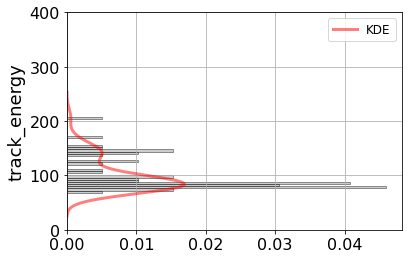

In [9]:
import seaborn as sns
from sklearn.neighbors import KernelDensity
from matplotlib import transforms
#fig, ax = plt.subplots(1, 2)
#fig.subplots_adjust(hspace=0.05, wspace=0.05)
xmin = 3100
xmax = 3200
tpc = 'iiwi'
X = uncorrected_recoils[tpc].loc[(uncorrected_recoils[tpc]['length']>xmin) & (uncorrected_recoils[tpc]['length']<xmax)]['track_energy'] 
sns.distplot(X, kde=True, rug=False, bins = 200, vertical = True, 
             kde_kws={"color": "red", "alpha": 0.5, "lw": 3, "label": "KDE"}, 
             hist_kws={"color": "gray", "edgecolor": "black", "range": (0,800)})
plt.ylim(0,400)
plt.grid()
#ax = X.plot.kde()
#ax.hist(X, bins = 50, range = (0,200), density = True)

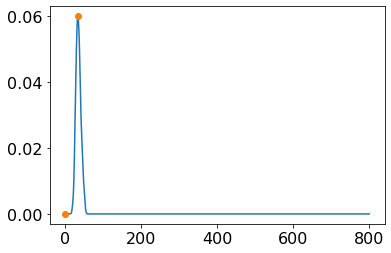

[14] [ 0.29600296 33.79233792]
0.1120011200112001 0.29600296002960025 0.6161275550559927


IndexError: index 1 is out of bounds for axis 0 with size 1

In [10]:
xmin = 1800
xmax = 1900
tpc = 'tako'
#X = uncorrected_recoils[tpc].loc[(uncorrected_recoils[tpc]['length']>xmin) & (uncorrected_recoils[tpc]['length']<xmax)]['track_energy'] 
X = uncorrected_red[tpc].loc[(uncorrected_red[tpc]['length']>xmin) & (uncorrected_red[tpc]['length']<xmax)]['track_energy'] 
# KDE instance
kde = gaussian_kde(dataset=X)

# compute KDE
gridsize = 801
x = np.linspace(0, 800, gridsize)
kde_values = kde(x)

#search for peaks
peaks, _ = find_peaks(kde(x))
prominences = peak_prominences(kde(x), peaks)[0]

peaks_df = pd.DataFrame()
peaks_df['peaks'] = peaks
peaks_df['prominences'] = prominences
peaks_df = peaks_df.sort_values('peaks')
index = peaks_df['prominences'].nlargest(2).index.to_numpy()
peaks = peaks_df['peaks'][index].to_numpy()

def get_left_reso(x, f, peak):
    interp = interp1d(x, f, kind='cubic')
    x_interp = np.linspace(0,800,100000)
    plt.plot(x_interp, interp(x_interp))
    crit = argrelextrema(interp(x_interp), np.greater, order = 10)
    df = pd.DataFrame()
    df['index'] = crit[0]
    df['extrema'] = [interp(x_interp)[crit[0][i]] for i in range(0,len(crit[0]))]
    index = df['extrema'].nlargest(2).index.to_numpy()
    peak = df['index'][index].to_numpy()
    peak = np.sort(peak)
    plt.plot(x_interp[peak], interp(x_interp)[peak], 'o')
    plt.show()
    half_max = interp(x_interp)[peak[0]]/2
    df = pd.DataFrame()
    df['x'] = x_interp
    df['f'] = interp(x_interp)
    df = df.loc[df['x'] < x_interp[peak[0]]]
    crit = df.loc[np.abs(half_max - df['f']) == np.abs((half_max - df['f'])).min()].index.to_numpy()
    width = x_interp[peak]-x_interp[crit]
    print(crit, width)
    return x_interp[crit][0], width[0], width[0]/x_interp[peak][0]*2/2.355 #gaussian approx

cl, wl, reso_He = get_left_reso(x, kde(x), peaks[0])
print(cl, wl, reso_He)

def get_right_reso(x, f, peak):
    half_max = f[peak]/2
    df = pd.DataFrame()
    df['x'] = x
    df['f'] = f
    df = df.loc[df['x'] > x[peak]]
    crit = df.loc[np.abs(half_max - df['f']) == np.abs((half_max - df['f'])).min()].index.to_numpy()
    x[peak]
    width = x[crit]-x[peak]
    return crit[0], width[0], width[0]/peak*2/2.355 #gaussian approx

cr, wr, reso_CO = get_right_reso(x, kde(x), peaks[1])


#plot results
plt.plot(x, kde_values, color = 'red', alpha = 0.5, lw = 3)
plt.vlines(x=peaks, ymin=0, ymax=kde(x)[peaks], linestyle = '--', lw = 1)
plt.plot(peaks, kde(x)[peaks], "x")
plt.xlim(0,800)

plt.hlines(kde(x[peaks[0]])/2, cl, cl+wl, color = 'red')
plt.hlines(kde(x[cr]), peaks[1], x[cr], color = 'blue')
sns.distplot(X, kde=True, rug=False, bins = 200, vertical = False, 
             kde_kws={"color": "red", "alpha": 0.5, "lw": 3, "label": "KDE"}, 
             hist_kws={"color": "gray", "edgecolor": "black", "range": (0,800)})
#print(reso_He,reso_CO,wl,wr,cl)

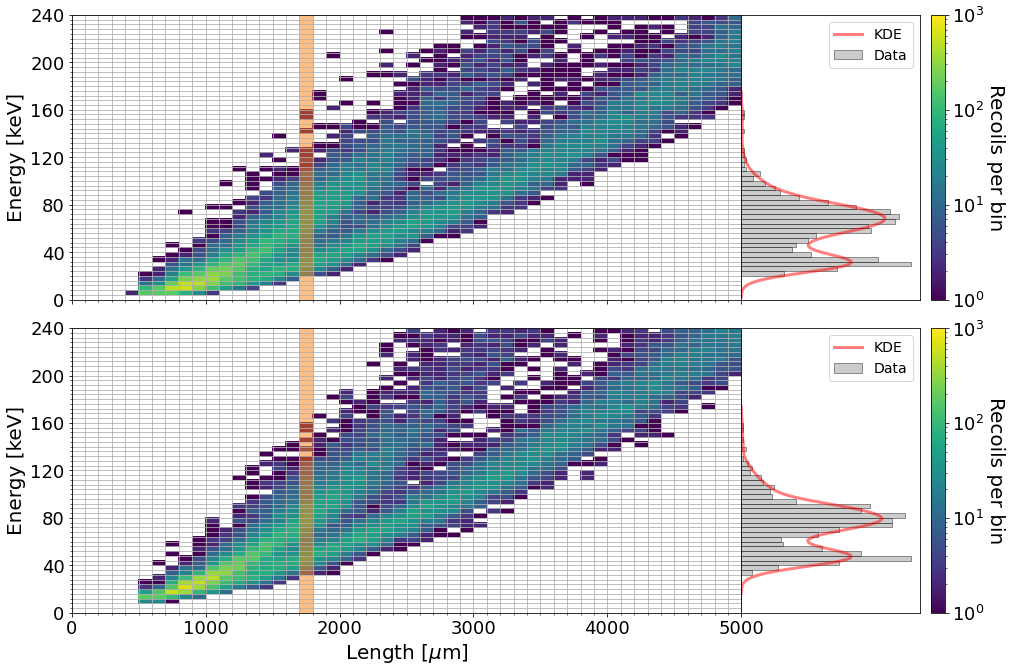

In [11]:
x_plt = np.linspace(0,800,801)
xm = 10000
ym = 800
nbinsx = int(xm/100)
nbinsy = int(ym/4)
sig_factor = 2 #Amount of sigmas away from Helium peak to define cutoff of leakage region

for tpc in ['tako']:
    for loc in range(17,18):
        ekey = 'track_energy'
        plt.rc('legend', fontsize=14)
        plt.rc('xtick', labelsize=18)
        plt.rc('ytick', labelsize=18)
        plt.rc('axes', labelsize=20)
        plt.rc('axes', titlesize=20)
        fig, ax = plt.subplots(2,2, figsize = (16,11), gridspec_kw={'hspace': 0.1, 'wspace': 0, 'width_ratios': [3, 1]})
        h[tpc + '_uncor'], xedges, yedges, image[tpc + '_uncor'] = ax[0,0].hist2d(uncorrected_recoils[tpc]['length'], uncorrected_recoils[tpc][ekey], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=1000))
        bins = 0.5*(yedges[1:]+yedges[:-1])
        plt.colorbar(image[tpc+'_uncor'], ax=[ax[0,1]]).set_label(r'Recoils per bin', rotation = 270, labelpad = 20)
        ax[0,0].set_xticklabels([])
        ax[0,0].yaxis.set_major_locator(MultipleLocator(40))
        ax[0,0].yaxis.set_minor_locator(MultipleLocator(4))
        ax[0,0].xaxis.set_minor_locator(MultipleLocator(100))
        ax[0,0].set_xlim(0,xm)
        ax[0,0].fill_between(np.array([xedges[loc], xedges[loc+1]]), 0, ym, alpha = 0.5, color = 'tab:orange')
        ax[0,0].set_ylim(0,240)
        ax[0,0].set_xlim(0,5000)
        ax[0,0].set_ylabel(r'Energy [keV]')
        ax[0,0].grid(which='both')
        X = uncorrected_recoils[tpc].loc[(uncorrected_recoils[tpc]['length']>xedges[loc]) & (uncorrected_recoils[tpc]['length']<xedges[loc+1])]['track_energy'] 
        sns.distplot(X, kde=True, rug=False, bins = nbinsy, vertical = True, ax = ax[0,1],
             kde_kws={"color": "red", "alpha": 0.5, "lw": 3, "label": "KDE"}, 
             hist_kws={"color": "gray", "edgecolor": "black", "range": (0,800), "label": "Data"})
        ax[0,1].set_ylim(0,240)
        ax[0,1].set_ylabel('')
        #ax[0,1].set_xlim(0,220)
        ax[0,1].set_yticks([])
        ax[0,1].set_xticks([])
        ax[0,1].legend()

        ekey = 'full_corrected_energy'
        h[tpc + '_cor'], xedges, yedges, image[tpc + '_cor'] = ax[1,0].hist2d(corrected_recoils[tpc]['length'], corrected_recoils[tpc][ekey], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=1000))
        plt.colorbar(image[tpc+'_cor'], ax=[ax[1,1]]).set_label(r'Recoils per bin', rotation = 270, labelpad = 20)
        ax[1,0].set_xticks([0,1000,2000,3000,4000, 5000, 6000])
        ax[1,0].yaxis.set_major_locator(MultipleLocator(40))
        ax[1,0].yaxis.set_minor_locator(MultipleLocator(4))
        ax[1,0].xaxis.set_minor_locator(MultipleLocator(100))
        ax[1,0].set_xlim(0,xm)
        ax[1,0].fill_between(np.array([xedges[loc], xedges[loc+1]]), 0, ym, alpha = 0.5, color = 'tab:orange')
        ax[1,0].set_ylim(0,240)
        ax[1,0].set_xlim(0,5000)
        ax[1,0].set_xlabel(r'Length [$\mu$m]')
        ax[1,0].set_ylabel(r'Energy [keV]')
        ax[1,0].grid(which='both')
        X = corrected_recoils[tpc].loc[(corrected_recoils[tpc]['length']>xedges[loc]) & (corrected_recoils[tpc]['length']<xedges[loc+1])]['full_corrected_energy'] 
        sns.distplot(X, kde=True, rug=False, bins = nbinsy, vertical = True, ax = ax[1,1],
             kde_kws={"color": "red", "alpha": 0.5, "lw": 3, "label": "KDE"}, 
             hist_kws={"color": "gray", "edgecolor": "black", "range": (0,800), "label": "Data"})
        ax[1,1].set_ylim(0,240)
        ax[1,1].set_ylabel('')
        #ax[1,1].set_xlim(0,220)
        ax[1,1].set_yticks([])
        ax[1,1].set_xticks([])
#plt.savefig('money2.png')
plt.show()

### Generate a bunch of plots for validation

In [18]:
x_plt = np.linspace(0,800,801)
xm = 10000
ym = 800
nbinsx = int(xm/100)
nbinsy = int(ym/4)

def get_He_reso(x, f, peak):
    interp = interp1d(x, f, kind='cubic')
    x_interp = np.linspace(0,800,100000)
    crit = argrelextrema(interp(x_interp), np.greater, order = 10)
    df = pd.DataFrame()
    df['index'] = crit[0]
    df['extrema'] = [interp(x_interp)[crit[0][i]] for i in range(0,len(crit[0]))]
    index = df['extrema'].nlargest(2).index.to_numpy()
    peak = df['index'][index].to_numpy()
    peak = np.sort(peak)
    half_max = interp(x_interp)[peak[0]]/2
    df = pd.DataFrame()
    df['x'] = x_interp
    df['f'] = interp(x_interp)
    df = df.loc[df['x'] < x_interp[peak[0]]]
    crit = df.loc[np.abs(half_max - df['f']) == np.abs((half_max - df['f'])).min()].index.to_numpy()
    width = x_interp[peak]-x_interp[crit]
    return x_interp[crit][0], width[0], width[0]/x_interp[peak][0]*2/2.355 #gaussian approx

#def get_He_reso(x, f, peak):
    #half_max = f[peak]/2
    #interp = interp1d(x, kde(x), kind='cubic')
    #x_interp = np.linspace(0,ym,100000)
    #crit = argrelextrema(interp(x_interp), np.greater)
    #print(len(crit))
    #df = pd.DataFrame()
    #df['x'] = x
    #df['f'] = f
    #df = df.loc[df['x'] < x[peak]]
    #crit = df.loc[np.abs(half_max - df['f']) == np.abs((half_max - df['f'])).min()].index.to_numpy()
    #width = x[peak]-x[crit]
    #return crit[0], width[0], width[0]/peak*2/2.355 #gaussian approx


for tpc in ['iiwi', 'nene', 'palila', 'tako', 'elepaio']:
    for loc in range(10,81):
        ekey = 'track_energy'
        fig, ax = plt.subplots(2,2, figsize = (8,7), gridspec_kw={'hspace': 0.1, 'wspace': 0, 'width_ratios': [3, 1]})
        h[tpc + '_uncor'], xedges, yedges, image[tpc + '_uncor'] = ax[0,0].hist2d(uncorrected_recoils[tpc]['length'], uncorrected_recoils[tpc][ekey], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=None))
        plt.colorbar(image[tpc+'_uncor'], ax=[ax[0,1]]).set_label(r'Recoils per bin', rotation = 270, labelpad = 20)
        ax[0,0].set_xticklabels([])
        ax[0,0].yaxis.set_minor_locator(AutoMinorLocator())
        ax[0,0].xaxis.set_minor_locator(AutoMinorLocator())
        ax[0,0].set_xlim(0,xm)
        ax[0,0].fill_between(np.array([xedges[loc], xedges[loc+1]]), 0, ym, alpha = 0.5, color = 'tab:orange')
        ax[0,0].set_ylim(0,ym)
        ax[0,0].set_ylabel(r'Energy [keV]')
        ax[0,0].grid(which='both')
        X = uncorrected_recoils[tpc].loc[(uncorrected_recoils[tpc]['length']>xedges[loc]) & (uncorrected_recoils[tpc]['length']<xedges[loc+1])]['track_energy'] 
        sns.distplot(X, kde=True, rug=False, bins = nbinsy, vertical = True, ax = ax[0,1],
             kde_kws={"color": "red", "alpha": 0.5, "lw": 1, "label": "KDE"}, 
             hist_kws={"color": "gray", "edgecolor": "black", "range": (0,800), "label": "Data"})
        
        # KDE instance
        kde = gaussian_kde(dataset=X)
        x = np.linspace(0, ym, ym+1)
        kde_values = kde(x)
        #search for peaks
        peaks, _ = find_peaks(kde(x))
        prominences = peak_prominences(kde(x), peaks)[0]
        #filter to highest two peaks using pandas
        peaks_df = pd.DataFrame()
        peaks_df['peaks'] = peaks
        peaks_df['prominences'] = prominences
        peaks_df = peaks_df.sort_values('peaks')
        index = peaks_df['prominences'].nlargest(2).index.to_numpy()
        peaks = peaks_df['peaks'][index].to_numpy()
        peaks = np.sort(peaks)
        
        #compute resolution
        cl, wl, reso_He = get_He_reso(x, kde(x), peaks[0])
        
        #plot peaks and HWHM
        ax[0,1].plot(kde(x)[peaks], peaks, "s", markersize = 6)
        ax[0,1].set_ylim(0,ym)
        ax[0,1].set_yticks([])
        ax[0,1].set_xticks([])
        ax[0,1].vlines(kde(x[peaks[0]])/2, cl, cl+wl, color = 'blue')

        ekey = 'full_corrected_energy'
        h[tpc + '_cor'], xedges, yedges, image[tpc + '_cor'] = ax[1,0].hist2d(corrected_recoils[tpc]['length'], corrected_recoils[tpc][ekey], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=None))
        plt.colorbar(image[tpc+'_cor'], ax=[ax[1,1]]).set_label(r'Recoils per bin', rotation = 270, labelpad = 20)
        ax[1,0].set_xticks([0,2000,4000,6000,8000])
        ax[1,0].yaxis.set_minor_locator(AutoMinorLocator())
        ax[1,0].xaxis.set_minor_locator(AutoMinorLocator())
        ax[1,0].set_xlim(0,xm)
        ax[1,0].fill_between(np.array([xedges[loc], xedges[loc+1]]), 0, ym, alpha = 0.5, color = 'tab:orange')
        ax[1,0].set_ylim(0,ym)
        ax[1,0].set_xlabel(r'Length [$\mu$m]')
        ax[1,0].set_ylabel(r'Energy [keV]')
        ax[1,0].grid(which='both')
        X = corrected_recoils[tpc].loc[(corrected_recoils[tpc]['length']>xedges[loc]) & (corrected_recoils[tpc]['length']<xedges[loc+1])]['full_corrected_energy'] 
        sns.distplot(X, kde=True, rug=False, bins = nbinsy, vertical = True, ax = ax[1,1],
             kde_kws={"color": "red", "alpha": 0.5, "lw": 1, "label": "KDE"}, 
             hist_kws={"color": "gray", "edgecolor": "black", "range": (0,800), "label": "Data"})
        
        # KDE instance
        kde = gaussian_kde(dataset=X)
        x = np.linspace(0, ym, ym+1)
        kde_values = kde(x)
        #search for peaks
        peaks, _ = find_peaks(kde(x))
        prominences = peak_prominences(kde(x), peaks)[0]
        #filter to highest two peaks using pandas
        peaks_df = pd.DataFrame()
        peaks_df['peaks'] = peaks
        peaks_df['prominences'] = prominences
        peaks_df = peaks_df.sort_values('peaks')
        index = peaks_df['prominences'].nlargest(2).index.to_numpy()
        peaks = peaks_df['peaks'][index].to_numpy()
        peaks = np.sort(peaks)
        
        #compute resolution
        cl, wl, reso_He = get_He_reso(x, kde(x), peaks[0])
        
        #plot peaks and HWHM
        ax[1,1].plot(kde(x)[peaks], peaks, "s", markersize = 6)
        ax[1,1].set_ylim(0,ym)
        ax[1,1].set_yticks([])
        ax[1,1].set_xticks([])
        ax[1,1].vlines(kde(x[peaks[0]])/2, cl, cl+wl, color = 'blue')
        plt.savefig('%s_hist_%s.png'%(tpc, loc))
        plt.clf()

/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memo

/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memo

/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memo

/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memo

/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memo

/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memo

/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memo

/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memo

/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memo

/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memo

/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memo

/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memo

/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memo

/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memo

/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memo

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

In [13]:
def get_resolution_and_leakage(xmax = 10000, ymax = 1000, nbinsx = 100, nbinsy = 250, tpcs = ['iiwi', 'nene', 'tako', 'palila', 'elepaio']):
    #Different outputs than before!!!
    #def get_He_reso(x, f, peak):
    #    interp = interp1d(x, f, kind='cubic')
    #    x_interp = np.linspace(0,800,100000)
    #    crit = argrelextrema(interp(x_interp), np.greater, order = 10)
    #    df = pd.DataFrame()
    #    df['index'] = crit[0]
    #    df['extrema'] = [interp(x_interp)[crit[0][i]] for i in range(0,len(crit[0]))]
    #    index = df['extrema'].nlargest(2).index.to_numpy()
    #    peak = df['index'][index].to_numpy()
    #    peak = np.sort(peak)
    #    half_max = interp(x_interp)[peak[0]]/2
    #    df = pd.DataFrame()
    #    df['x'] = x_interp
    #    df['f'] = interp(x_interp)
    #    df = df.loc[df['x'] < x_interp[peak[0]]]
    #    crit = df.loc[np.abs(half_max - df['f']) == np.abs((half_max - df['f'])).min()].index.to_numpy()
    #    width = x_interp[peak]-x_interp[crit]
    #    return x_interp[crit][0], width[0]*2/2.355, width[0]/x_interp[peak][0]*2/2.355 #gaussian approx
    def get_He_reso(x, f, peak):
        half_max = f[peak]/2
        df = pd.DataFrame()
        df['x'] = x
        df['f'] = f
        df = df.loc[df['x'] < x[peak]]
        crit = df.loc[np.abs(half_max - df['f']) == np.abs((half_max - df['f'])).min()].index.to_numpy()
        width = x[peak]-x[crit]
        return x[crit[0]], width[0]*2/2.355, width[0]/peak*2/2.355 #gaussian approx
    h = {}
    image = {}
    reso_dfs = {}
    sig_factor = 2
    for tpc in tpcs:
        resolution = {}
        h[tpc+'_uncor'], xedges, yedges, image[tpc+'_uncor'] = plt.hist2d(uncorrected_recoils[tpc]['length'], uncorrected_recoils[tpc]['track_energy'], bins = (nbinsx,nbinsy), range = ((0,xmax),(0,ymax)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=1000))
        h[tpc+'_cor'], xedges, yedges, image[tpc+'_cor'] = plt.hist2d(corrected_recoils[tpc]['length'], corrected_recoils[tpc]['full_corrected_energy'], bins = (nbinsx,nbinsy), range = ((0,xmax),(0,ymax)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=1000))
        plt.clf()
        bins = 0.5*(yedges[1:]+yedges[:-1])
        resolution['length'] = []
        resolution['energy_uncor'] = []
        resolution['energy_uncor_err'] = []
        resolution['energy_cor'] = []
        resolution['energy_cor_err'] = []
        resolution['reso_uncor'] = []
        resolution['reso_cor'] = []
        dx = int(xmax/nbinsx)
        if tpc == 'iiwi':
            imin = int(1600/dx)
            imax = 57
            #imax = 80
        elif tpc == 'nene':
            imin = int(1500/dx)
            imax = 60
            #imax = 90
        elif tpc == 'tako':
            imin = int(1400/dx)
            imax = 95
        elif tpc == 'palila':
            imin = int(1700/dx)
            imax = 59
            #imax = 85
        elif tpc == 'elepaio':
            imin = int(1600/dx)
            imax = 60
            #imax = 90
        for i in range(imin,imax):
            resolution['length'].append(dx*(2*i+1)/2)
            for ekey in ['track_energy', 'full_corrected_energy']:
                if ekey == 'track_energy':
                    #df = uncorrected_recoils[tpc]
                    df = uncorrected_red[tpc]
                else:
                    #df = corrected_recoils[tpc]
                    df = corrected_red[tpc]
                    
                X = df.loc[(df['length']>(i*dx)) & (corrected_recoils[tpc]['length']<((i+1)*dx))][ekey]
                # KDE instance
                kde = gaussian_kde(dataset=X)
                x = np.linspace(0, ym, ym+1)
                kde_values = kde(x)
                #search for peaks
                peaks, _ = find_peaks(kde(x))
                prominences = peak_prominences(kde(x), peaks)[0]
                #filter to highest two peaks using pandas
                peaks_df = pd.DataFrame()
                peaks_df['peaks'] = peaks
                peaks_df['prominences'] = prominences
                peaks_df = peaks_df.sort_values('peaks')
                index = peaks_df['prominences'].nlargest(2).index.to_numpy()
                peaks = peaks_df['peaks'][index].to_numpy()
                peaks = np.sort(peaks)
                
                #compute resolution
                E, sigE, reso_He = get_He_reso(x, kde(x), peaks[0])
                if ekey == 'track_energy':
                    resolution['energy_uncor'].append(E)
                    resolution['energy_uncor_err'].append(sigE)
                    resolution['reso_uncor'].append(reso_He)
                else:
                    resolution['energy_cor'].append(E)
                    resolution['energy_cor_err'].append(sigE)
                    resolution['reso_cor'].append(reso_He)
        reso_dfs[tpc] = pd.DataFrame.from_dict(resolution)
    return reso_dfs


### Get resolutions

In [100]:
dfs = get_resolution_and_leakage()

<Figure size 432x288 with 0 Axes>

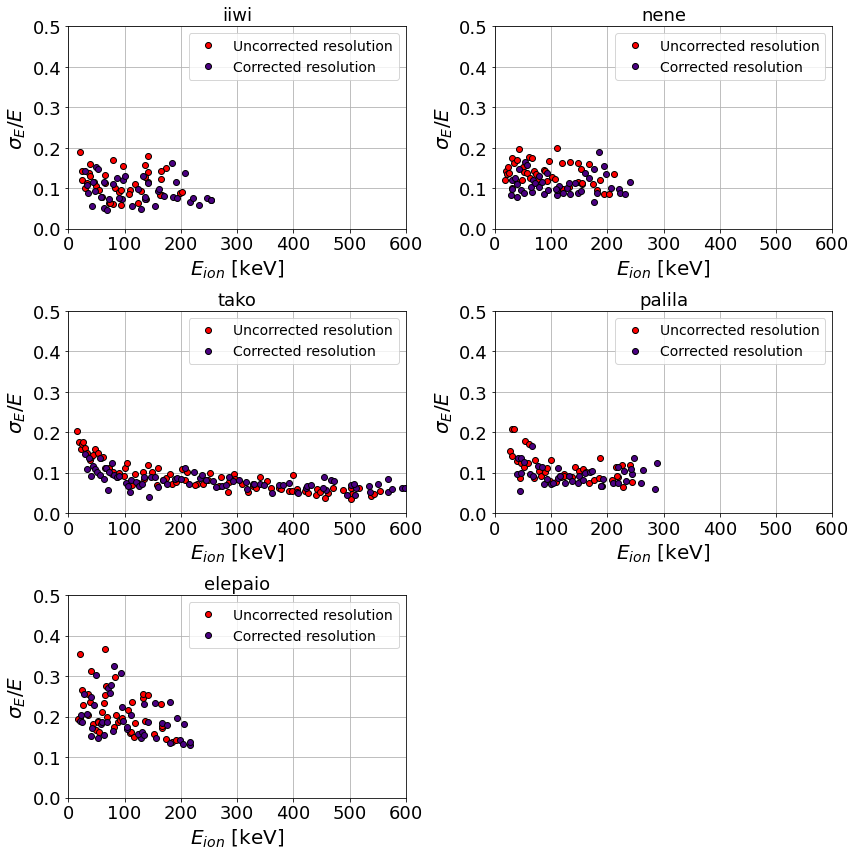

In [101]:
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
i = 1
plt.figure(figsize = (12,12))
for tpc in ['iiwi', 'nene', 'tako', 'palila', 'elepaio']:
    plt.subplot(3,2,i)
    plt.plot(dfs[tpc]['energy_uncor'],np.abs(dfs[tpc]['reso_uncor']), 'o', color = 'red', label = 'Uncorrected resolution', markeredgecolor = 'black')
    plt.plot(dfs[tpc]['energy_cor'],np.abs(dfs[tpc]['reso_cor']), 'o', color = 'indigo', label = 'Corrected resolution', markeredgecolor = 'black')
    plt.ylabel(r'$\sigma_E/E$')
    #plt.xlabel(r'Length [um]')
    plt.xlabel(r'$E_{ion}$ [keV]')
    plt.xlim(0,600)
    plt.ylim(0,0.5)
    plt.title(tpc)
    plt.grid()
    plt.legend()
    i+=1
plt.tight_layout()
#plt.savefig('tako_leakage.png')
plt.show()

### Add simulation

In [35]:
s = pc.simulation()
zmin = 0
zmax = 10
IQF_group, after_thresh_group = s.get_grouped_MC(recoil_species = 'He', zmin = zmin, zmax = zmax) #can add zmin and zmax as 0 and 10 to remove fiducial cuts
after_thresh = s.apply_energy_calibrations(recoil_species = 'He', zmin = zmin, zmax = zmax)[0]

### Charge loss after gain
For now do for He only. Possibly make a function to add C and O later if we decide to measure the energy resolution of C/O reocils in data

In [36]:
gain = {'iiwi': 1502, 'nene': 899, 'humu': 878, 'palila': 1033, 'tako': 807, 'elepaio': 797}
W = 35.075
fpath = '~/data/phase3/simulation/resolution_paper/tpc_sims/'
reco_E = {}
truth_E = {}
truth_index = {}
after_gain_raw = {} #dict of dataframes to use, will groupby() truth energies
for tpc in ['iiwi', 'nene', 'palila', 'tako', 'elepaio']:
    '''
    if tpc == 'iiwi':
        energies = np.array([i for i in range (5,29)] + [10*i for i in range(3, 11)] 
+ [120,140,160,180,200,250,300,350,400,450,500,600,700,800])
    elif tpc == 'palila' or tpc == 'nene':
        energies = np.array([i for i in range (5,29)] + [10*i for i in range(3, 11)] 
+ [120,140,160,180,200,250,300,350,400,450,500,600,700,800,900])
    else:
        energies = np.array([i for i in range (5,29)] + [10*i for i in range(3, 11)] 
+ [120,140,160,180,200,250,300,350,400,450,500,600,700,800,900,1000])
    '''
    energies = np.array([i for i in range (5,29)] + [10*i for i in range(3, 11)] 
+ [120,140,160,180,200,250,300,350,400,450,500]) #cap at 500 for now while files generate
    reco_E[tpc] = []
    truth_E[tpc] = []
    truth_index[tpc] = []
    for energy in energies:
        f = ROOT.TFile(fpath + '%s_%s_keV.root'%(tpc, energy))
        charge = []
        for i in range(1,101):
            after_gain = ROOT.TH3D(f.Get("event_fe4_after_gain_proj_0_1_2;%s"%(i)))
            charge.append(after_gain.GetEntries())
            truth_E[tpc].append(energy)
            reco_E[tpc].append(after_gain.GetEntries()*35.075*1e-03/gain[tpc])
            truth_index[tpc].append(i-1)
    after_gain_raw[tpc] = pd.DataFrame()
    after_gain_raw[tpc]['E_truth'] = truth_E[tpc]
    after_gain_raw[tpc]['E_reco'] = reco_E[tpc]
    after_gain_raw[tpc]['truth_index'] = truth_index[tpc]


### Use truth indices to find after gain events that should be removed due to fiducial cuts

In [37]:
for tpc in ['iiwi', 'nene', 'palila', 'tako', 'elepaio']:
    energies = after_thresh[tpc]['truth_energy'].unique()
    temp = after_gain_raw[tpc].head(0)
    for e in energies:
        truth_index = after_thresh[tpc].loc[after_thresh[tpc]['truth_energy'] == e]['truth_index'] #after thresh has been subject to fiducial cuts from simulation class
        temp = temp.append(after_gain_raw[tpc].loc[(after_gain_raw[tpc]['E_truth']==e) & (after_gain_raw[tpc]['truth_index'].isin(truth_index)==True)], ignore_index = True)
    after_gain_raw[tpc] = temp

In [38]:
after_gain_group = {}
for tpc in ['iiwi', 'nene', 'palila', 'tako', 'elepaio']:
    after_gain_group[tpc] = after_gain_raw[tpc].groupby('E_truth')

### Plot ratio of ionization energy to truth energy vs truth energy for various stages of the event

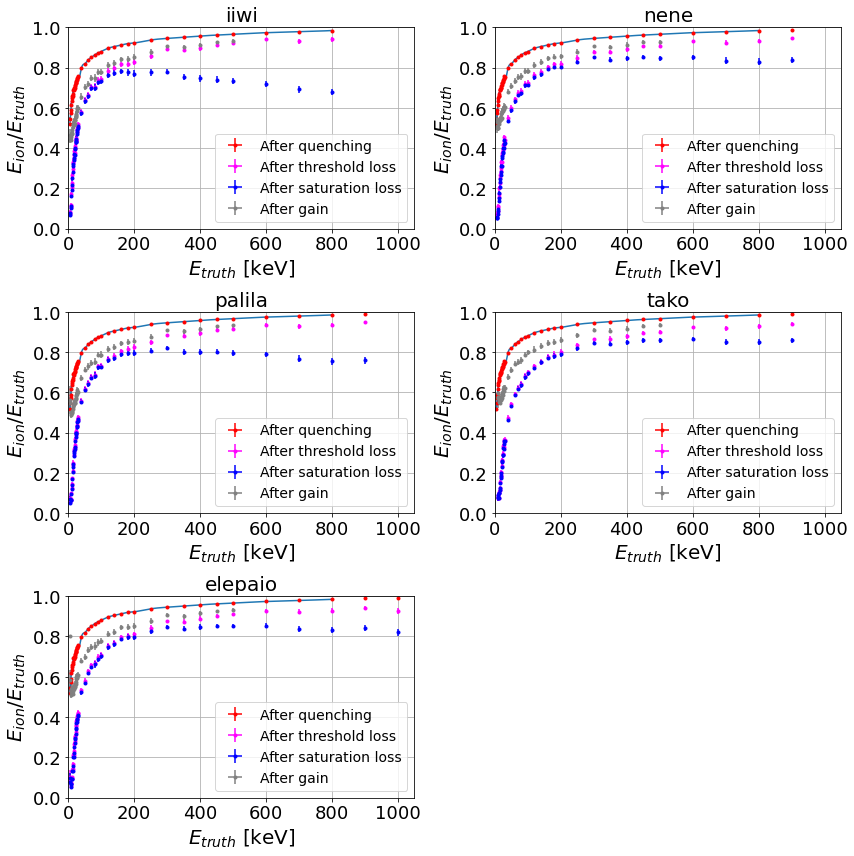

In [39]:
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
plt.rc('axes', titlesize=20)
plt.figure(figsize = (12,12))
i=1
for tpc in ['iiwi', 'nene', 'palila', 'tako', 'elepaio']:
    plt.subplot(3,2,i)
    plt.errorbar(IQF_group[tpc].mean().index,
                 IQF_group[tpc].mean()['truth_charge']*35.075*1e-03/IQF_group[tpc].mean().index,
                 IQF_group[tpc].sem()['truth_charge']*35.075*1e-03/IQF_group[tpc].mean().index,
                 [0 for i in range(0,len(IQF_group[tpc].mean()))],
                 'o',markersize = 3, label = r'After quenching', color = 'red')

    plt.errorbar(after_thresh_group[tpc].mean().index,
                 (after_thresh_group[tpc].mean()['qsum']*35.075*1e-03/gain[tpc])/after_thresh_group[tpc].mean().index,
                 (after_thresh_group[tpc].sem()['qsum']*35.075*1e-03/gain[tpc])/after_thresh_group[tpc].mean().index,
                 [0 for i in range(0,len(after_thresh_group[tpc].mean()))],
                 'o',markersize = 3, label = r'After threshold loss', color = 'magenta')

    plt.errorbar(after_thresh_group[tpc].mean().index,
                 (after_thresh_group[tpc].mean()['sumtot']*35.075*1e-03/gain[tpc])/after_thresh_group[tpc].mean().index,
                 (after_thresh_group[tpc].sem()['sumtot']*35.075*1e-03/gain[tpc])/after_thresh_group[tpc].mean().index,
                 [0 for i in range(0,len(after_thresh_group[tpc].mean()))],
                 'o',markersize = 3, label = r'After saturation loss', color = 'blue')
    plt.errorbar(after_gain_group[tpc].mean().index,
                 (after_gain_group[tpc].mean()['E_reco'])/after_gain_group[tpc].mean().index,
                 (after_gain_group[tpc].sem()['E_reco'])/after_gain_group[tpc].mean().index,
                 [0 for i in range(0,len(after_gain_group[tpc].mean()))],
                 'o',markersize = 3, label = r'After gain', color = 'gray')

    f = interp1d(IQF_group[tpc].mean().index, IQF_group[tpc].mean()['truth_charge']*35.075*1e-03/IQF_group[tpc].mean().index, kind = 'cubic')
    x = np.linspace(5,800,100000)
    plt.plot(x, f(x))
    plt.ylabel(r'$E_{ion}/E_{truth}$')
    plt.xlabel(r'$E_{truth}$ [keV]')
    plt.ylim(0,1)
    plt.xlim(0,1050)
    plt.legend(loc ='lower right')
    plt.grid()
    plt.title(tpc)
    i+=1
plt.tight_layout()
plt.show()

### RMS reconstructed energies to get uncertainty in simulation resolution

In [40]:
h_thresh_sat = {}
h_thresh = {}
h_quench = {}
h_gain = {}
vals_thresh_sat = {}
vals_thresh = {}
vals_quench = {}
vals_gain = {}
rms_errors_quench = {}
rms_errors_thresh = {}
rms_errors_thresh_sat = {}
rms_errors_gain = {}

for tpc in ['iiwi', 'nene', 'palila', 'tako', 'elepaio']:
    rms_errors_quench[tpc] = []
    rms_errors_thresh[tpc] = []
    rms_errors_thresh_sat[tpc] = []
    rms_errors_gain[tpc] = []
    for energy in after_thresh[tpc]['truth_energy'].unique(): #thresh and saturation
        h_thresh_sat[tpc+'_'+str(energy)] = ROOT.TH1F('%s_%s'%(tpc,energy), '%s_%s'%(tpc,energy), 21, 0, 100)
        h_thresh[tpc+'_'+str(energy)] = ROOT.TH1F('%s_%s'%(tpc,energy), '%s_%s'%(tpc,energy), 21, 0, 100)
        vals_thresh_sat[tpc+'_'+str(energy)] = array.array('d', after_thresh_group[tpc].mean().loc[after_thresh[tpc]['truth_energy'] == energy]['sumtot']*W*1e-03/gain[tpc])
        vals_thresh[tpc+'_'+str(energy)] = array.array('d', after_thresh_group[tpc].mean().loc[after_thresh[tpc]['truth_energy'] == energy]['qsum']*W*1e-03/gain[tpc])
        for i in range(0,len(vals_thresh_sat[tpc+'_'+str(energy)])):
            h_thresh_sat[tpc+'_'+str(energy)].Fill(vals_thresh_sat[tpc+'_'+str(energy)][i])
        for i in range(0,len(vals_thresh[tpc+'_'+str(energy)])):
            h_thresh[tpc+'_'+str(energy)].Fill(vals_thresh[tpc+'_'+str(energy)][i])
        rms_errors_thresh_sat[tpc].append(h_thresh_sat[tpc+'_'+str(energy)].GetRMSError())
        rms_errors_thresh[tpc].append(h_thresh[tpc+'_'+str(energy)].GetRMSError())
    for energy in after_gain_raw[tpc]['E_truth'].unique(): #gain
        h_gain[tpc+'_'+str(energy)] = ROOT.TH1F('%s_%s'%(tpc,energy), '%s_%s'%(tpc,energy), 21, 0, 100)
        vals_gain[tpc+'_'+str(energy)] = array.array('d', after_gain_group[tpc].mean().loc[after_gain_raw[tpc]['E_truth'] == energy]['E_reco'])
        for i in range(0,len(vals_gain[tpc+'_'+str(energy)])):
            h_gain[tpc+'_'+str(energy)].Fill(vals_gain[tpc+'_'+str(energy)][i])
        rms_errors_gain[tpc].append(h_gain[tpc+'_'+str(energy)].GetRMSError())
    rms_errors_thresh_sat[tpc] = np.array(rms_errors_thresh_sat[tpc])
    rms_errors_thresh[tpc] = np.array(rms_errors_thresh[tpc])
    rms_errors_quench[tpc] = np.array(rms_errors_quench[tpc])
    rms_errors_gain[tpc] = np.array(rms_errors_gain[tpc])

Warning in <TROOT::Append>: Replacing existing TH1: iiwi_5.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_6.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_7.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_8.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_9.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_10.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_11.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_12.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_13.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_14.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_15.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing T

In [41]:
reso_errors_thresh_sat = {}
reso_errors_thresh = {}
reso_errors_gain = {}
for tpc in ['iiwi', 'nene', 'palila', 'tako', 'elepaio']:
    reso_errors_thresh[tpc] = (after_thresh_group[tpc].std()['qsum']*35.075*1e-03/gain[tpc])/(after_thresh_group[tpc].mean()['qsum']*35.075*1e-03/gain[tpc]) * np.sqrt((rms_errors_thresh[tpc]/(after_thresh_group[tpc].std()['qsum']*35.075*1e-03)/gain[tpc])**2 + ((after_thresh_group[tpc].std()['qsum']*35.075*1e-03/gain[tpc])/(after_thresh_group[tpc].mean()['qsum']*35.075*1e-03/gain[tpc]))**2)
    reso_errors_thresh_sat[tpc] = (after_thresh_group[tpc].std()['sumtot']*35.075*1e-03/gain[tpc])/(after_thresh_group[tpc].mean()['sumtot']*35.075*1e-03/gain[tpc]) * np.sqrt((rms_errors_thresh_sat[tpc]/(after_thresh_group[tpc].std()['sumtot']*35.075*1e-03)/gain[tpc])**2 + ((after_thresh_group[tpc].std()['sumtot']*35.075*1e-03/gain[tpc])/(after_thresh_group[tpc].mean()['sumtot']*35.075*1e-03/gain[tpc]))**2)
    reso_errors_gain[tpc] = after_gain_group[tpc].std()['E_reco']/(after_gain_group[tpc].mean()['E_reco']) * np.sqrt((rms_errors_gain[tpc]/(after_gain_group[tpc].std()['E_reco'])**2 + ((after_gain_group[tpc].std()['E_reco'])/(after_gain_group[tpc].mean()['E_reco']))**2))

### Removed IQF division from corrected energy. Check with Sven of if I should use that or if I should interpolate based on the corrected energy reco:truth ratio

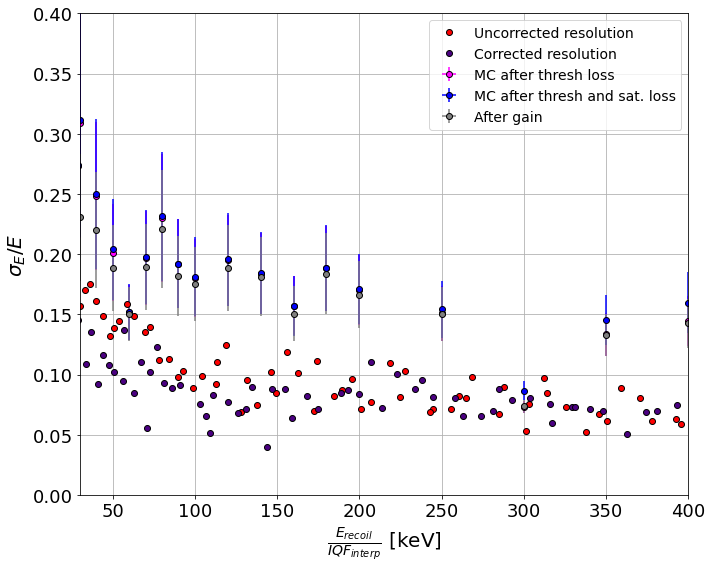

In [103]:
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
for tpc in ['tako']:
    fig, ax = plt.subplots(figsize = (10,8))
    #index = dfs[tpc].loc[dfs[tpc]['length']<10000].index.to_numpy()
    index = dfs[tpc].index.to_numpy()
    #Divide x axis by interpolation of IQF curve
    ax.plot(dfs[tpc]['energy_uncor']/f(dfs[tpc]['energy_uncor']),np.abs(dfs[tpc]['reso_uncor']), 'o', color = 'red', label = 'Uncorrected resolution', markeredgecolor = 'black')
    ax.plot(dfs[tpc]['energy_cor'],np.abs(dfs[tpc]['reso_cor']), 'o', color = 'indigo', label = 'Corrected resolution', markeredgecolor = 'black')
    ax.errorbar(after_thresh_group[tpc].mean().index,
                 (after_thresh_group[tpc].std()['qsum']*35.075*1e-03/gain[tpc])/(after_thresh_group[tpc].mean()['qsum']*35.075*1e-03/gain[tpc]),
                 reso_errors_thresh[tpc], [0 for i in range(0,len(reso_errors_thresh[tpc]))],
                 'o', label = r'MC after thresh loss', color = 'magenta', markeredgecolor = 'black')
    ax.errorbar(after_thresh_group[tpc].mean().index,
                 (after_thresh_group[tpc].std()['sumtot']*35.075*1e-03/gain[tpc])/(after_thresh_group[tpc].mean()['sumtot']*35.075*1e-03/gain[tpc]),
                 reso_errors_thresh_sat[tpc], [0 for i in range(0,len(reso_errors_thresh_sat[tpc]))],
                 'o', label = r'MC after thresh and sat. loss', color = 'blue', markeredgecolor = 'black')
    ax.errorbar(after_gain_group[tpc].mean().index,
                 after_gain_group[tpc].std()['E_reco']/after_gain_group[tpc].mean()['E_reco'],
                     reso_errors_gain[tpc], [0 for i in range(0,len(reso_errors_gain[tpc]))],
                 'o', label = r'After gain', color = 'gray', markeredgecolor = 'black')
    ax.set_ylabel(r'$\sigma_E/E$')
    ax.set_xlabel(r'$\frac{E_{recoil}}{IQF_{interp}}$ [keV]')
    ax.set_xlim(30,400)
    ax.set_ylim(0,0.4)
    ax.grid()
    plt.legend()
plt.tight_layout()
#plt.savefig('tako_leakage.png')
plt.show()

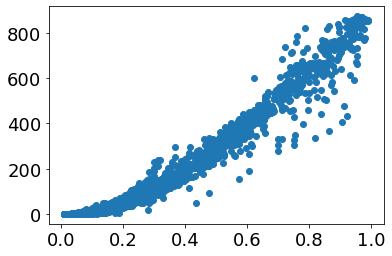

In [50]:
plt.plot(after_thresh['tako']['fit_length'], after_thresh['tako']['reco_energy'], 'o')